In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [2]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
## WRITE OR READ FROM S3 ####
import boto3
import io

s3 = boto3.resource('s3')
output_bucket = "hbo-outbound-datascience-content-dev"
input_bucket = "hbo-ingest-datascience-content-dev"
bucket = s3.Bucket(input_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
def write_to_input(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=input_bucket, Key=filename, Body=content)
    
def read_from_s3(filename, input_bucket = input_bucket):
    for obj in bucket.objects.filter(Prefix=filename): #churn_metric_0811
            key = obj.key 
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            df = pd.read_csv(body, na_values = [r'\\\\N'])
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [4]:
churn_metric = read_from_s3('cost_allocation/dev/churn_metric_0906')
churn_metric.head()

Reading cost_allocation/dev/churn_metric_0906.csv features


,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


In [5]:
hours_viewed = read_from_s3('title_hours_viewed_retention/validation_data.csv')

Reading title_hours_viewed_retention/validation_data.csv features


In [6]:
hours_viewed = hours_viewed[['title_name', 'title_id', 'season_number', 'offering_start_date' , 'ahvr', 'pillar_genre', 'medal', 'content_category', 'asset_run_time_hours']]
hours_viewed.rename(columns = {'ahvr':'average_hours_viewed_60d', 'pillar_genre': 'genre', 'content_category':'category'}, inplace = True)

In [7]:
hours_viewed.loc[hours_viewed['genre'] == 'Action/Adventure ', 'genre'] = 'action'
hours_viewed.loc[hours_viewed['genre'] == 'Comedy', 'genre'] = 'comedy'
hours_viewed.loc[hours_viewed['genre'] == 'Drama', 'genre'] = 'drama'
hours_viewed.loc[~hours_viewed['genre'].isin(['action', 'comedy', 'drama']), 'genre'] = 'other'

hours_viewed.loc[hours_viewed['medal'] == 'None', 'medal'] = 'Bronze'

hours_viewed.loc[hours_viewed['category'] == 'special', 'category'] = 'movies'

In [8]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','category', 'churn_per_hr_person']], on = ['genre','medal','category'])

In [9]:
hours_viewed['change_in_churn_60d'] = hours_viewed['average_hours_viewed_60d'] * hours_viewed['churn_per_hr_person']

In [10]:
hours_viewed_thresh = hours_viewed[hours_viewed['average_hours_viewed_60d'] >= 0.01]

# Allocate the 60-Day Churn to monthly

## First 60 Allocation

In [11]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 60, 1)]

In [12]:
hours_viewed_thresh['key'] = 1
dt_df['key'] = 1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [13]:
hours_viewed_60d = hours_viewed_thresh.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_60d['request_date'] = pd.to_datetime(hours_viewed_60d['offering_start_date']) \
                                    + pd.to_timedelta(hours_viewed_60d['days_on_hbo_max'], unit='D')

hours_viewed_60d['change_in_churn'] = hours_viewed_60d['change_in_churn_60d']/60

## After 60 Day Allocation

In [16]:
ever_green_titles = read_from_s3('title_hours_viewed_retention/final_evergreen_title_list.csv') #final_evergreen_title_list.csv # ever_green_titles.csv

Reading title_hours_viewed_retention/final_evergreen_title_list.csv features


In [17]:
ever_green_title_id = ever_green_titles.title_id.unique()

In [18]:
norm_title_id = hours_viewed_thresh[~hours_viewed_thresh['title_id'].isin(ever_green_title_id)].title_id.unique()

### 1. Normal Titles

In [19]:
from scipy.optimize import curve_fit

In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [21]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## 90% of the retention value deteriorates in the first year
x = [0, 0.8, 5]
y = [1, 0.1, 0.0001]

popt, pcov = curve_fit(func, x, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [22]:
x1 = pd.Series(np.arange(0,5,0.1))
y1 = func(x1, *popt)

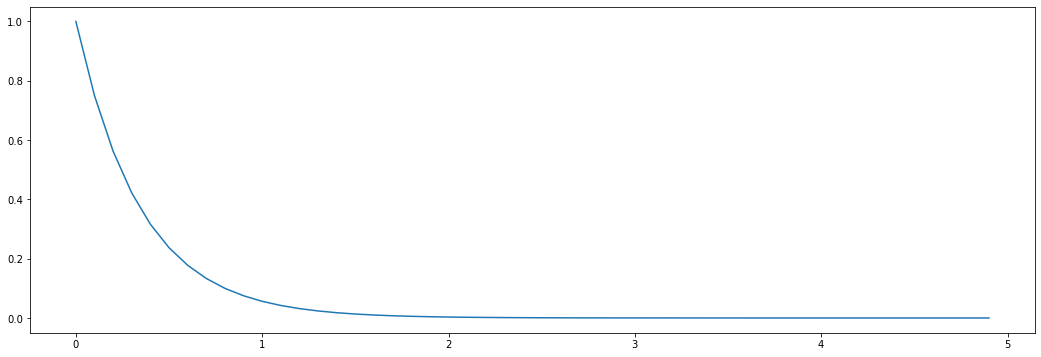

In [23]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x1, y1)
plt.show()

In [24]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365, 1)]
dt_df['factor'] = func(dt_df['days_on_hbo_max']/365, *popt)
dt_df['key'] = 1

In [25]:
hours_viewed_decay_norm = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(norm_title_id)]

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_norm['change_in_churn'] = hours_viewed_decay_norm['change_in_churn_60d']/60*hours_viewed_decay_norm['factor']

hours_viewed_decay_norm['days_on_hbo_max'] = hours_viewed_decay_norm['days_on_hbo_max']+60

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

hours_viewed_decay_norm = hours_viewed_decay_norm[hours_viewed_decay_norm['request_date'] <= '2023-03-01']


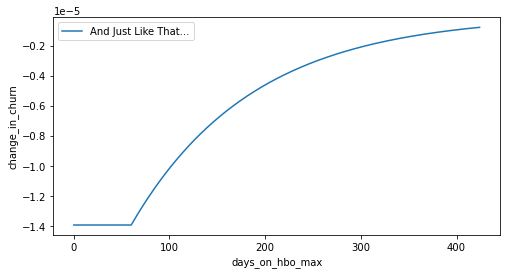

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max','change_in_churn']]],
                axis = 0)
plot_df = test[test['title_name'] == 'And Just Like That...']
plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label='And Just Like That...')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

### 2. Evergreen Titles

#### 2.1 Sogmoid Decay

In [27]:
# ## 90% of the retention value is deteriorated in the first year
# x = [0, 0.25, 1.5, 3]
# y = [1, 0.99, 0.5, 0.001]

# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0))) + b
#     return (y)

# p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, x, y ,p0, method='dogbox')

# x1 = pd.Series(np.arange(0,5,0.1))
# y1 = sigmoid(x1, *popt)

# fig, ax = plt.subplots(figsize=(18, 6))
# plt.plot(x1, y1)
# plt.show()

In [28]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['factor'] = sigmoid(dt_df['days_on_hbo_max']/365, *popt)
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['factor']

# hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [29]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
#                 axis = 0)


# for i in range(1, 11, 1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

#### 2.2 Keep the retention value all the way along

In [30]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
dt_df['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60

hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


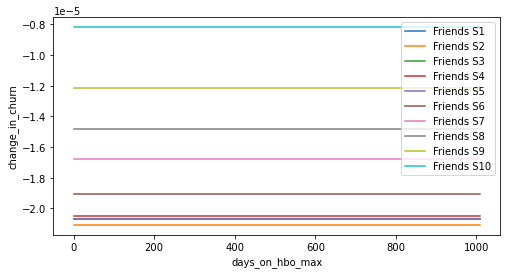

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

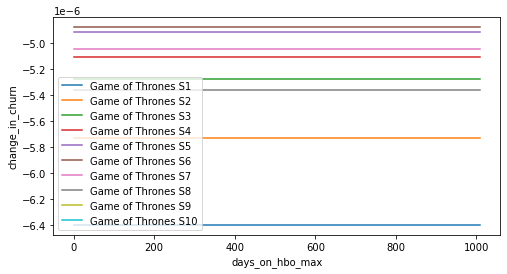

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Game of Thrones') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Game of Thrones S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

## UNION ALL THE DFs

In [33]:
data = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']] ],
                axis = 0)

In [34]:
data['date_month'] = data['request_date'].dt.to_period('M')

# Correlation with Change in Churn

## 1. Correlation with Churn itself

In [38]:
churn_genpop = read_from_s3('title_hours_viewed_retention/churn_genpop.csv')
churn_genpop_tenure = read_from_s3('title_hours_viewed_retention/churn_genpop_tenure.csv')
churn_exclude_t1 = read_from_s3('title_hours_viewed_retention/churn_exclude_t1.csv')

Reading title_hours_viewed_retention/churn_genpop.csv features
Reading title_hours_viewed_retention/churn_genpop_tenure.csv features
Reading title_hours_viewed_retention/churn_exclude_t1.csv features


In [42]:
churn_genpop['total_subscriber'] = churn_genpop.groupby(['date_month'])['subscriber_count'].transform('sum')
churn_genpop['churn_rate'] = churn_genpop['subscriber_count']/churn_genpop['total_subscriber']
churn_genpop = churn_genpop[churn_genpop['is_cancel'] == True]

churn_genpop_tenure['total_subscriber'] = churn_genpop_tenure.groupby(['date_month', 'sub_month'])['subscriber_count'].transform('sum')
churn_genpop_tenure['churn_rate'] = churn_genpop_tenure['subscriber_count']/churn_genpop_tenure['total_subscriber']
churn_genpop_tenure = churn_genpop_tenure[churn_genpop_tenure['is_cancel'] == True]

churn_exclude_t1['total_subscriber'] = churn_exclude_t1.groupby(['date_month'])['subscriber_count'].transform('sum')
churn_exclude_t1['churn_rate'] = churn_exclude_t1['subscriber_count']/churn_exclude_t1['total_subscriber']
churn_exclude_t1 = churn_exclude_t1[churn_exclude_t1['is_cancel'] == True]

In [43]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

#### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2021-12-01']

#### Shift one month forward
# aggregated_churn['date_month']  = (pd.to_datetime(aggregated_churn['date_month']) + pd.DateOffset(months=1)).dt.strftime('%Y-%m-%d')

In [45]:
churn_genpop_tenure_pivot = pd.pivot_table(churn_genpop_tenure, values='churn_rate', index=['date_month'],
                       columns=['sub_month'], fill_value=0, aggfunc='first').reset_index()

In [46]:
churn_all = churn_genpop_tenure_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [47]:
churn_all['date_month'] = churn_all['date_month'].astype(str)

In [48]:
churn_all.head()

,date_month,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,genpop_churn,churn_exclude_t1
0,2022-01-01,0.248178,0.155623,0.121944,0.109274,0.095811,0.090610,0.065764,0.061678,0.065651,...,0.026609,0.022625,0.017091,0.017563,0.039216,0.000000,0.000000,0.105263,0.088450,0.065103
1,2022-02-01,0.220287,0.145717,0.113277,0.095207,0.087219,0.079466,0.076550,0.057955,0.055873,...,0.032054,0.027833,0.028498,0.025038,0.015653,0.064220,0.037500,0.041667,0.077640,0.065185
2,2022-03-01,0.246934,0.160222,0.118878,0.093951,0.081534,0.073291,0.068943,0.067792,0.049941,...,0.030673,0.026484,0.023890,0.020491,0.015798,0.018299,0.031915,0.012821,0.077198,0.061731
3,2022-04-01,0.249417,0.176824,0.129607,0.104879,0.086425,0.074453,0.071057,0.066796,0.064316,...,0.028576,0.030031,0.026565,0.023560,0.020790,0.015309,0.015662,0.048193,0.075261,0.063931
4,2022-05-01,0.248945,0.159699,0.131202,0.102014,0.085766,0.073494,0.065372,0.063088,0.059888,...,0.028315,0.026931,0.029020,0.025223,0.021892,0.018683,0.014673,0.015955,0.070928,0.057973


In [49]:
churn_all = churn_all.merge(aggregated_churn, on = ['date_month'])

In [50]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = [i for i in range(1, 25)]+['genpop_churn', 'churn_exclude_t1']

In [51]:
for i in FEATURE_COLS:
    churn_all[i] = churn_all[i].astype(float)

In [52]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [53]:
plot_data=churn_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
1,-0.387155
2,-0.201117
3,-0.051742
4,-0.168411
5,0.001315
6,-0.114168
7,0.087900
8,0.064176
9,-0.012802
10,-0.047798


<AxesSubplot:>

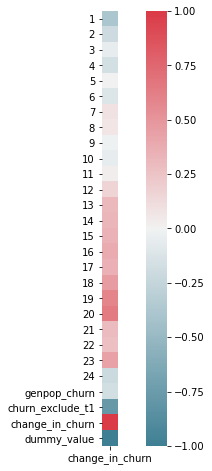

In [54]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

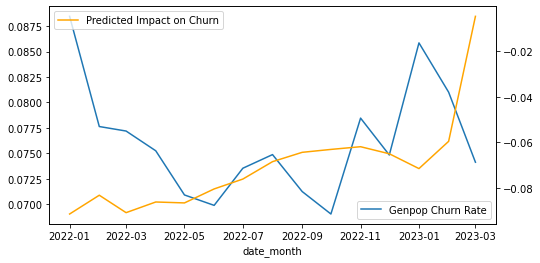

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df['genpop_churn'], label= 'Genpop Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

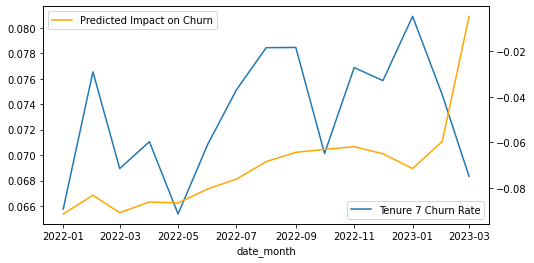

In [56]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df[7], label= 'Tenure 7 Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

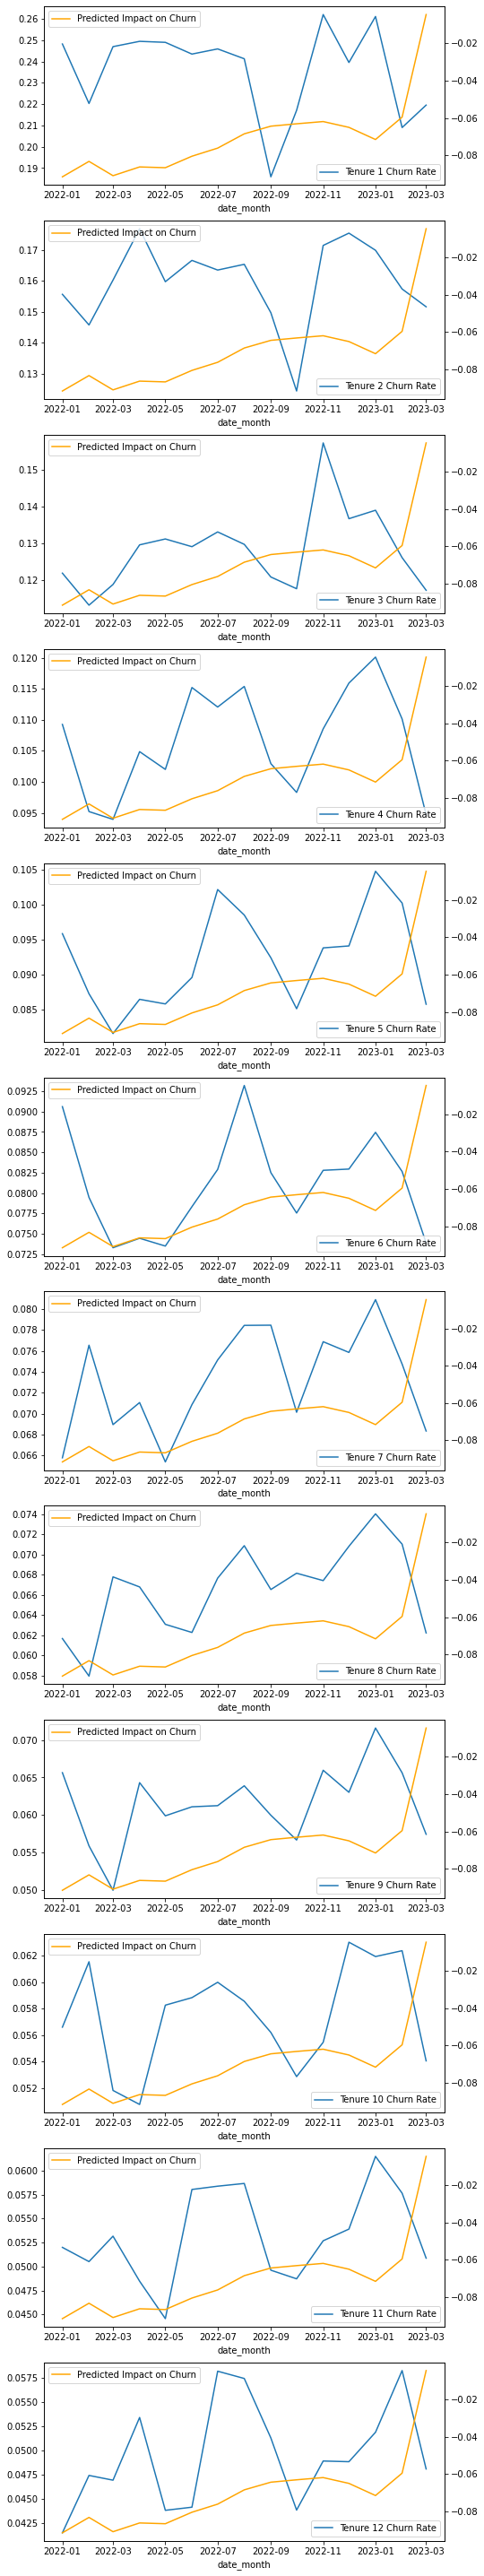

In [57]:
# fig, ax = plt.subplots(figsize=(8, 4))
plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
fig, ax = plt.subplots(12,1,figsize=(8, 52))

for i in range(0, 12, 1):
    ax1 = ax[i]
    ax1.plot(plot_df['date_month'], plot_df[i+1], label= 'Tenure ' + str(i+1)+ ' Churn Rate')

    ax2 = ax[i].twinx()
    ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

    ax1.set_xlabel('date_month')
    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'upper left')

plt.show()
    

## 2. Correlation with Tenure Buckets

In [58]:
churn_genpop_tenure_bucekts = read_from_s3('title_hours_viewed_retention/churn_genpop_tenure_bucekts.csv')

Reading title_hours_viewed_retention/churn_genpop_tenure_bucekts.csv features


In [59]:
churn_genpop_tenure_bucekts['total_subscriber'] = churn_genpop_tenure_bucekts.groupby(['date_month', 'tenure'])['subscriber_count'].transform('sum')
churn_genpop_tenure_bucekts['churn_rate'] = churn_genpop_tenure_bucekts['subscriber_count']/churn_genpop_tenure_bucekts['total_subscriber']
churn_genpop_tenure_bucekts = churn_genpop_tenure_bucekts[churn_genpop_tenure_bucekts['is_cancel'] == True]

In [60]:
churn_genpop_tenure_bucekts_pivot = pd.pivot_table(churn_genpop_tenure_bucekts, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [61]:
churn_bucekts_all = churn_genpop_tenure_bucekts_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [62]:
churn_bucekts_all['date_month'] = churn_bucekts_all['date_month'].astype(str)

In [63]:
churn_bucekts_all = churn_bucekts_all.merge(aggregated_churn, on = ['date_month'])

In [64]:
churn_bucekts_all.head()

,date_month,Month 1,Month 13+,Month 2,Month 3,Month 4-6,Month 7-12,genpop_churn,churn_exclude_t1,change_in_churn
0,2022-01-01,0.248178,0.027454,0.155623,0.121944,0.097306,0.058601,0.088450,0.065103,-0.091546
1,2022-02-01,0.220287,0.031318,0.145717,0.113277,0.087883,0.057947,0.077640,0.065185,-0.083281
2,2022-03-01,0.246934,0.028062,0.160222,0.118878,0.084423,0.054719,0.077198,0.061731,-0.090947
3,2022-04-01,0.249417,0.030444,0.176824,0.129607,0.091658,0.056716,0.075261,0.063931,-0.086256
4,2022-05-01,0.248945,0.031517,0.159699,0.131202,0.087960,0.054532,0.070928,0.057973,-0.086668


In [69]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = ['Month 1','Month 2', 'Month 3', 'Month 4-6','Month 7-12', 'Month 13+','genpop_churn',]

In [70]:
for i in FEATURE_COLS:
    churn_bucekts_all[i] = churn_bucekts_all[i].astype(float)

In [71]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [72]:
plot_data=churn_bucekts_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
Month 1,-0.387155
Month 2,-0.201117
Month 3,-0.051742
Month 4-6,-0.125947
Month 7-12,0.202834
Month 13+,-0.005103
genpop_churn,-0.172343
change_in_churn,1.000000
dummy_value,-1.000000


<AxesSubplot:>

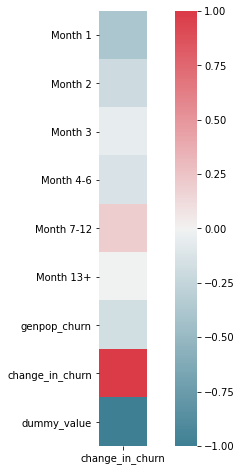

In [73]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Write to S3/SF

In [75]:
write_to_sf(data, 'daily_monthly_retention_value')

In [90]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format('daily_monthly_retention_value')

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/daily_monthly_retention_value.csv'